# PyTorch Wine Quality NN (11→64→32→1)

Neues Notebook zur Vorhersage der Weinqualität mit einem Feedforward-Netz (11 Eingangsmerkmale → 64 → 32 → 1). Das Training speichert History, Gewichte und Scaler nach `NN_model_history/` und nutzt den Datensatz `Base-Data/winequality-red.csv`.


In [125]:
import os
import time
import random
import json
import copy
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from scipy import stats
import scipy.stats as sp_stats
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# KONFIGURATION (VERBESSERT)
# ============================================================================
SEED = 42
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4  # L2 Regularisierung
MAX_EPOCHS = 400  # ERHÖHT von 200
PATIENCE = 20  # ERHÖHT von 10
DATA_PATH = Path("Base-Data/winequality-red.csv")
ARTIFACT_DIR = Path("NN_model_history")
ARTIFACT_DIR.mkdir(exist_ok=True)

# Outlier Behandlung (gleich wie Random Forest)
OUTLIER_THRESHOLD = 3.0  # Entferne Zeilen mit Z-Score > 3
OUTLIER_FEATURES = ['residual sugar', 'chlorides']

# LR Scheduler
USE_LR_SCHEDULER = True
LR_SCHEDULER_PATIENCE = 10
LR_SCHEDULER_FACTOR = 0.5

# Loss Function: 'mse', 'huber', 'mae'
LOSS_FUNCTION = 'mse'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(SEED)
sns.set_theme(style="whitegrid")

print("=" * 70)
print("KONFIGURATION (VERBESSERTE VERSION)")
print("=" * 70)
print(f"Device: {device}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay (L2): {WEIGHT_DECAY}")
print(f"Max Epochs: {MAX_EPOCHS} (erhöht)")
print(f"Early Stopping Patience: {PATIENCE} (erhöht)")
print(f"LR Scheduler: {'AKTIVIERT' if USE_LR_SCHEDULER else 'DEAKTIVIERT'}")
print(f"Loss Function: {LOSS_FUNCTION}")
print(f"Outlier Threshold: Z-Score > {OUTLIER_THRESHOLD}")
print("=" * 70)


KONFIGURATION (VERBESSERTE VERSION)
Device: cuda
Batch Size: 32
Learning Rate: 0.001
Weight Decay (L2): 0.0001
Max Epochs: 400 (erhöht)
Early Stopping Patience: 20 (erhöht)
LR Scheduler: AKTIVIERT
Loss Function: mse
Outlier Threshold: Z-Score > 3.0


In [126]:
# ============================================================================
# DATEN LADEN UND BEREINIGEN
# ============================================================================
df = pd.read_csv(DATA_PATH)
print(f"Originaler Datensatz: {df.shape}")
print(df.head())

# ============================================================================
# DUPLIKATE ENTFERNEN
# ============================================================================
initial_shape = df.shape[0]
df_clean = df.drop_duplicates()
after_duplicates = df_clean.shape[0]
duplicates_removed = initial_shape - after_duplicates

print("\n" + "=" * 70)
print("DUPLIKATE ENTFERNEN")
print("=" * 70)
print(f"Ursprüngliche Anzahl Zeilen: {initial_shape}")
print(f"Nach Entfernen von Duplikaten: {after_duplicates}")
print(f"Entfernte Duplikate: {duplicates_removed}")
print("=" * 70)

# ============================================================================
# AUSREISSER BEHANDELN (Z-Score Methode - gleich wie Random Forest)
# ============================================================================
feature_cols = [c for c in df_clean.columns if c != "quality"]

print("\n" + "=" * 70)
print("AUSREISSER-BEHANDLUNG (Z-Score Methode)")
print("=" * 70)

# Statistiken VOR Ausreißer-Entfernung
print(f"\nStatistiken VOR Ausreißer-Entfernung für kritische Features:")
for feature in OUTLIER_FEATURES:
    print(f"  {feature}: Mean={df_clean[feature].mean():.4f}, Std={df_clean[feature].std():.4f}")

# Z-Score berechnen
z_scores = np.abs(stats.zscore(df_clean[feature_cols]))
outlier_mask = (z_scores < OUTLIER_THRESHOLD).all(axis=1)
df_no_outliers = df_clean[outlier_mask].copy()
outliers_removed = after_duplicates - df_no_outliers.shape[0]

print(f"\nZeilen vor Ausreißer-Entfernung: {after_duplicates}")
print(f"Zeilen nach Ausreißer-Entfernung: {df_no_outliers.shape[0]}")
print(f"Entfernte Ausreißer: {outliers_removed} ({100*outliers_removed/after_duplicates:.1f}%)")

# Statistiken NACH Ausreißer-Entfernung
print(f"\nStatistiken NACH Ausreißer-Entfernung für kritische Features:")
for feature in OUTLIER_FEATURES:
    print(f"  {feature}: Mean={df_no_outliers[feature].mean():.4f}, Std={df_no_outliers[feature].std():.4f}")

print("\n" + "=" * 70)
print("ZUSAMMENFASSUNG DATENBEREINIGUNG")
print("=" * 70)
print(f"Original: {initial_shape} → Nach Duplikate: {after_duplicates} → Nach Ausreißer: {df_no_outliers.shape[0]}")
print(f"Gesamte Reduktion: {initial_shape - df_no_outliers.shape[0]} Zeilen ({100*(initial_shape - df_no_outliers.shape[0])/initial_shape:.1f}%)")
print("=" * 70)

# Finaler Datensatz
df_final = df_no_outliers.copy()

# Features und Target
X = df_final[feature_cols].astype(np.float32).values
y = df_final["quality"].astype(np.float32).values.reshape(-1, 1)

print(f"\nFinaler Datensatz: {df_final.shape}")
print(f"Features: {len(feature_cols)} → {feature_cols}")


Originaler Datensatz: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.

In [127]:
test_size = 0.15
val_ratio = 0.15 / (1 - test_size)

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=test_size, random_state=SEED, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=val_ratio, random_state=SEED, shuffle=True
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(
    f"Split sizes → train: {X_train.shape[0]}, val: {X_val.shape[0]}, test: {X_test.shape[0]} | features: {X_train.shape[1]}"
)


Split sizes → train: 867, val: 186, test: 186 | features: 11


In [128]:
class WineDataset(Dataset):
    def __init__(self, features: np.ndarray, targets: np.ndarray):
        self.X = torch.from_numpy(features).float()
        self.y = torch.from_numpy(targets).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


train_ds = WineDataset(X_train_scaled, y_train)
val_ds = WineDataset(X_val_scaled, y_val)
test_ds = WineDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

next(iter(train_loader))[0].shape


torch.Size([32, 11])

In [129]:
# ============================================================================
# VERBESSERTE NEURAL NETWORK ARCHITEKTUR
# Mit BatchNorm und Dropout für bessere Generalisierung
# ============================================================================

class WineQualityNet(nn.Module):
    """
    Verbesserte Architektur: 11 → 128 → 64 → 32 → 1
    Mit BatchNorm nach jedem Linear Layer und Dropout nach ReLU
    """
    def __init__(self, in_features: int = 11, hidden1: int = 128, hidden2: int = 64, 
                 hidden3: int = 32, dropout_rate: float = 0.25):
        super().__init__()
        self.net = nn.Sequential(
            # Layer 1: in → 128
            nn.Linear(in_features, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Layer 2: 128 → 64
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Layer 3: 64 → 32
            nn.Linear(hidden2, hidden3),
            nn.BatchNorm1d(hidden3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output Layer: 32 → 1
            nn.Linear(hidden3, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# Alte Architektur zum Vergleich (optional)
class WineQualityNetOld(nn.Module):
    """Original Architektur: 11 → 64 → 32 → 1 (ohne BatchNorm/Dropout)"""
    def __init__(self, in_features: int = 11, hidden1: int = 64, hidden2: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


model = WineQualityNet(in_features=len(feature_cols)).to(device)

# Zeige Modell-Architektur
print("=" * 70)
print("VERBESSERTE NEURAL NETWORK ARCHITEKTUR")
print("=" * 70)
print(f"\nArchitektur: {len(feature_cols)} → 128 → 64 → 32 → 1")
print(f"Mit BatchNorm und Dropout (rate=0.25)")
print(f"\nModell-Details:")
print(model)
print(f"\nAnzahl Parameter: {sum(p.numel() for p in model.parameters()):,}")
print("=" * 70)


VERBESSERTE NEURAL NETWORK ARCHITEKTUR

Architektur: 11 → 128 → 64 → 32 → 1
Mit BatchNorm und Dropout (rate=0.25)

Modell-Details:
WineQualityNet(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Anzahl Parameter: 12,353


In [130]:
# ============================================================================
# VERBESSERTE TRAINING-FUNKTIONEN
# Mit LR Scheduler, Weight Decay (L2), verschiedene Loss Functions
# ============================================================================

def get_loss_function(loss_type: str = 'mse'):
    """Gibt die Loss-Funktion basierend auf dem Typ zurück"""
    if loss_type == 'mse':
        return nn.MSELoss()
    elif loss_type == 'huber':
        return nn.HuberLoss(delta=1.0)  # Robuster gegen Ausreißer
    elif loss_type == 'mae':
        return nn.L1Loss()
    else:
        raise ValueError(f"Unbekannte Loss-Funktion: {loss_type}")


def run_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    total_loss, total_mae, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train_mode:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                preds = model(xb)
                loss = criterion(preds, yb)

        total_loss += loss.item() * xb.size(0)
        total_mae += torch.nn.functional.l1_loss(preds, yb, reduction="sum").item()
        n += xb.size(0)

    return total_loss / n, total_mae / n


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                max_epochs: int = MAX_EPOCHS, patience: int = PATIENCE,
                use_scheduler: bool = USE_LR_SCHEDULER, loss_type: str = LOSS_FUNCTION):
    """
    Verbesserte Training-Funktion mit:
    - Weight Decay (L2 Regularisierung)
    - Learning Rate Scheduler (ReduceLROnPlateau)
    - Verschiedene Loss Functions (MSE, Huber, MAE)
    """
    criterion = get_loss_function(loss_type)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # LR Scheduler: Reduziere LR wenn Validation Loss stagniert
    scheduler = None
    if use_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, 
                                       patience=LR_SCHEDULER_PATIENCE, verbose=True)

    history = []
    lr_history = []
    best_state = copy.deepcopy(model.state_dict())
    best_val = float("inf")
    best_epoch = 0
    epochs_no_improve = 0

    print(f"Training gestartet mit Loss: {loss_type}, Weight Decay: {WEIGHT_DECAY}")
    print(f"LR Scheduler: {'aktiviert' if use_scheduler else 'deaktiviert'}")
    print("-" * 50)
    
    start_time = time.time()
    for epoch in range(1, max_epochs + 1):
        train_loss, train_mae = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_mae = run_epoch(model, val_loader, criterion, optimizer=None)
        
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_mae": train_mae,
            "val_mae": val_mae,
            "learning_rate": current_lr
        })
        
        # LR Scheduler Step
        if scheduler is not None:
            scheduler.step(val_loss)

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Progress ausgeben alle 50 Epochen
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, LR={current_lr:.6f}")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch} (best epoch {best_epoch})")
            break

    training_time = time.time() - start_time
    model.load_state_dict(best_state)

    print(f"\nTraining abgeschlossen!")
    print(f"Best Epoch: {best_epoch}, Best Val Loss: {best_val:.4f}")
    print(f"Training Zeit: {training_time:.2f}s")

    return pd.DataFrame(history), best_epoch, training_time

def evaluate_split(model: nn.Module, features: np.ndarray, targets: np.ndarray):
    model.eval()
    with torch.no_grad():
        preds = model(torch.from_numpy(features).float().to(device)).cpu().numpy().reshape(-1)
    y_true = targets.reshape(-1)

    mse = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}, preds


def round_preds(preds: np.ndarray, min_label: int = 0, max_label: int = 10) -> np.ndarray:
    preds_round = np.rint(preds).astype(int)
    return np.clip(preds_round, min_label, max_label)


def accuracy_from_preds(preds: np.ndarray, targets: np.ndarray, min_label: int = 0, max_label: int = 10):
    y_true = targets.reshape(-1).astype(int)
    y_pred = round_preds(preds, min_label=min_label, max_label=max_label)
    acc = (y_pred == y_true).mean()
    return acc, y_pred

In [131]:
model = WineQualityNet(in_features=X_train_scaled.shape[1]).to(device)

history_df, best_epoch, training_time = train_model(
    model, train_loader, val_loader, max_epochs=MAX_EPOCHS, patience=PATIENCE
)

print(f"Best epoch: {best_epoch} | training time: {training_time:.2f}s")
history_df.tail()


Training gestartet mit Loss: mse, Weight Decay: 0.0001
LR Scheduler: aktiviert
--------------------------------------------------


C:\Users\dchmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 50: Train Loss=1.2649, Val Loss=0.6826, LR=0.001000
Epoch 100: Train Loss=1.0447, Val Loss=0.6432, LR=0.000125

Early stopping at epoch 129 (best epoch 109)

Training abgeschlossen!
Best Epoch: 109, Best Val Loss: 0.5410
Training Zeit: 17.94s
Best epoch: 109 | training time: 17.94s


,epoch,train_loss,val_loss,train_mae,val_mae,learning_rate
124,125,0.983055,0.639820,0.784748,0.629335,0.000063
125,126,1.039980,0.608232,0.800952,0.608844,0.000063
126,127,1.026003,0.613643,0.792351,0.618162,0.000063
127,128,0.997240,0.566241,0.792165,0.600329,0.000063
128,129,1.124768,0.597671,0.842993,0.612026,0.000063


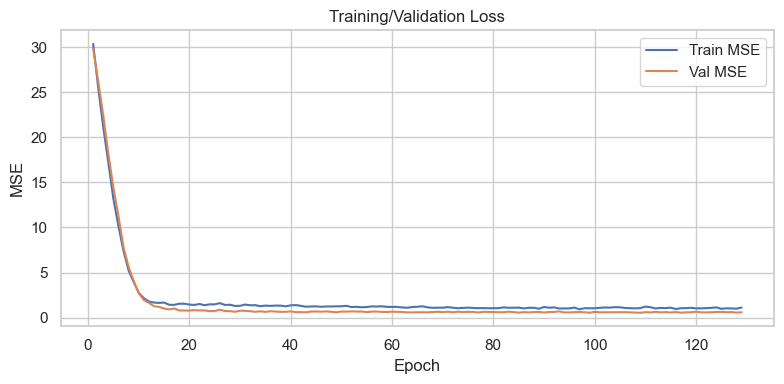

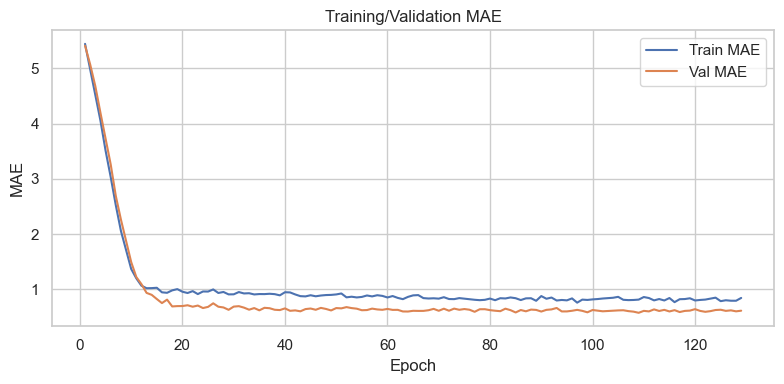

In [132]:
plt.figure(figsize=(8, 4))
plt.plot(history_df["epoch"], history_df["train_loss"], label="Train MSE")
plt.plot(history_df["epoch"], history_df["val_loss"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training/Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_df["epoch"], history_df["train_mae"], label="Train MAE")
plt.plot(history_df["epoch"], history_df["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training/Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
train_metrics, train_preds = evaluate_split(model, X_train_scaled, y_train)
val_metrics, val_preds = evaluate_split(model, X_val_scaled, y_val)
test_metrics, test_preds = evaluate_split(model, X_test_scaled, y_test)

train_acc, train_preds_rounded = accuracy_from_preds(train_preds, y_train)
val_acc, val_preds_rounded = accuracy_from_preds(val_preds, y_val)
test_acc, test_preds_rounded = accuracy_from_preds(test_preds, y_test)

metrics_df = pd.DataFrame(
    [
        {**train_metrics, "acc": train_acc},
        {**val_metrics, "acc": val_acc},
        {**test_metrics, "acc": test_acc},
    ],
    index=["train", "val", "test"],
)

correct_test = int((test_preds_rounded == y_test.reshape(-1).astype(int)).sum())
total_test = len(y_test)
print(f"Test Accuracy (rounded to int): {test_acc:.3f} ({correct_test}/{total_test} korrekt)")
metrics_df.round(4)


Test Accuracy (rounded to int): 0.591 (110/186 korrekt)


,mse,rmse,mae,r2,acc
train,0.3556,0.5963,0.4597,0.4827,0.6125
val,0.5410,0.7356,0.5738,0.2173,0.5645
test,0.4102,0.6405,0.5073,0.2043,0.5914


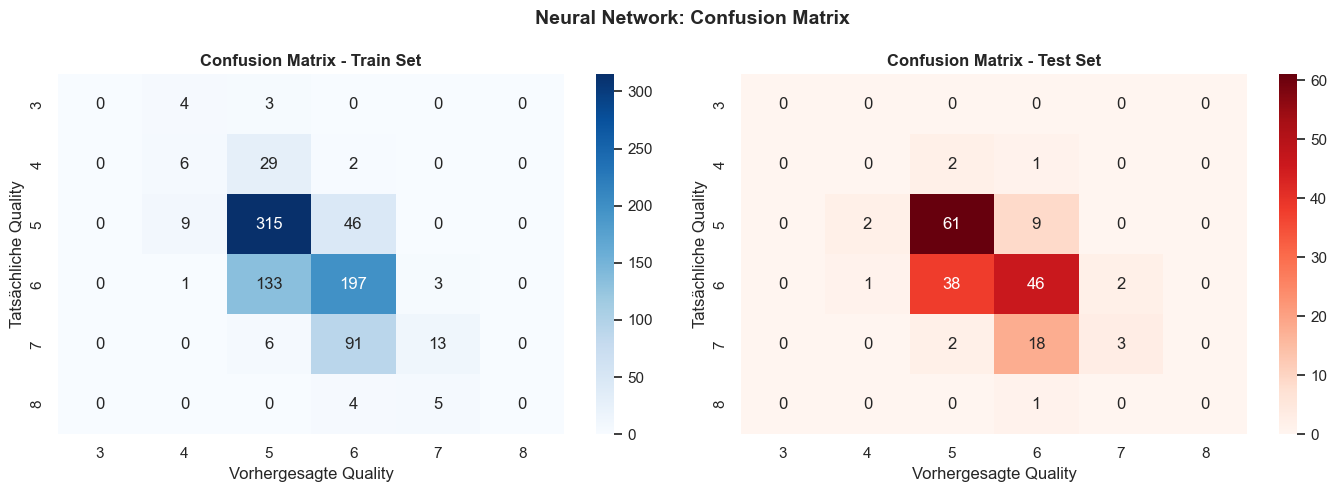


Accuracy (gerundete Vorhersagen):
  Train: 0.6125
  Val:   0.5645
  Test:  0.5914


In [134]:
# ============================================================================
# CONFUSION MATRIX: Vorhersagen auf ganze Zahlen runden
# ============================================================================

# Predictions runden und clippen
y_train_pred_rounded = np.clip(np.round(train_preds), 3, 8).astype(int)
y_val_pred_rounded = np.clip(np.round(val_preds), 3, 8).astype(int)
y_test_pred_rounded = np.clip(np.round(test_preds), 3, 8).astype(int)

# Targets als Integer
y_train_int = y_train.reshape(-1).astype(int)
y_val_int = y_val.reshape(-1).astype(int)
y_test_int = y_test.reshape(-1).astype(int)

# Confusion Matrix berechnen
labels = sorted(np.unique(np.concatenate([y_train_int, y_val_int, y_test_int])))
cm_train = confusion_matrix(y_train_int, y_train_pred_rounded, labels=labels)
cm_test = confusion_matrix(y_test_int, y_test_pred_rounded, labels=labels)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Vorhergesagte Quality', fontsize=12)
axes[0].set_ylabel('Tatsächliche Quality', fontsize=12)
axes[0].set_title('Confusion Matrix - Train Set', fontweight='bold')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', 
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Vorhergesagte Quality', fontsize=12)
axes[1].set_ylabel('Tatsächliche Quality', fontsize=12)
axes[1].set_title('Confusion Matrix - Test Set', fontweight='bold')

plt.suptitle('Neural Network: Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAccuracy (gerundete Vorhersagen):")
print(f"  Train: {train_acc:.4f}")
print(f"  Val:   {val_acc:.4f}")
print(f"  Test:  {test_acc:.4f}")


PER-QUALITY PERFORMANCE ANALYSE (Test Set)




,Quality,N_Samples,MAE,Accuracy,Mean_Pred,Bias
0,4,3,1.1954,0.0000,5.1954,1.1954
1,5,72,0.2870,0.8472,5.1173,0.1173
2,6,87,0.5309,0.5287,5.6145,-0.3855
3,7,23,0.9593,0.1304,6.0407,-0.9593
4,8,1,1.8530,0.0000,6.1470,-1.8530


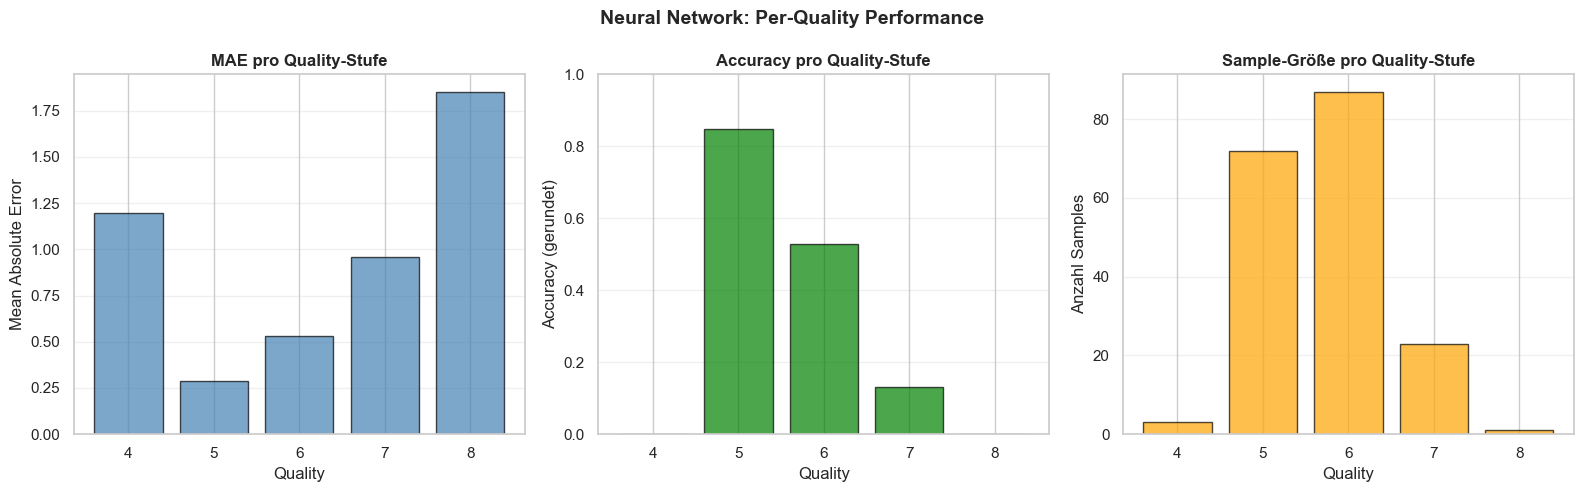

In [135]:
# ============================================================================
# PER-QUALITY PERFORMANCE ANALYSE
# ============================================================================

print("=" * 80)
print("PER-QUALITY PERFORMANCE ANALYSE (Test Set)")
print("=" * 80)

quality_analysis = []
for q in sorted(np.unique(y_test_int)):
    mask = y_test_int == q
    n_samples = mask.sum()
    
    if n_samples > 0:
        q_actual = y_test_int[mask]
        q_pred = test_preds[mask]
        q_pred_rounded = y_test_pred_rounded[mask]
        
        mae = mean_absolute_error(q_actual, q_pred)
        accuracy = (q_pred_rounded == q_actual).mean()
        mean_pred = q_pred.mean()
        
        quality_analysis.append({
            'Quality': q,
            'N_Samples': n_samples,
            'MAE': mae,
            'Accuracy': accuracy,
            'Mean_Pred': mean_pred,
            'Bias': mean_pred - q
        })

quality_df = pd.DataFrame(quality_analysis)
print("\n")
display(quality_df.round(4))

# Visualisierung
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MAE pro Quality
axes[0].bar(quality_df['Quality'], quality_df['MAE'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error', fontsize=12)
axes[0].set_title('MAE pro Quality-Stufe', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Accuracy pro Quality
axes[1].bar(quality_df['Quality'], quality_df['Accuracy'], color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Accuracy (gerundet)', fontsize=12)
axes[1].set_title('Accuracy pro Quality-Stufe', fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

# Samples pro Quality
axes[2].bar(quality_df['Quality'], quality_df['N_Samples'], color='orange', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Quality', fontsize=12)
axes[2].set_ylabel('Anzahl Samples', fontsize=12)
axes[2].set_title('Sample-Größe pro Quality-Stufe', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Neural Network: Per-Quality Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


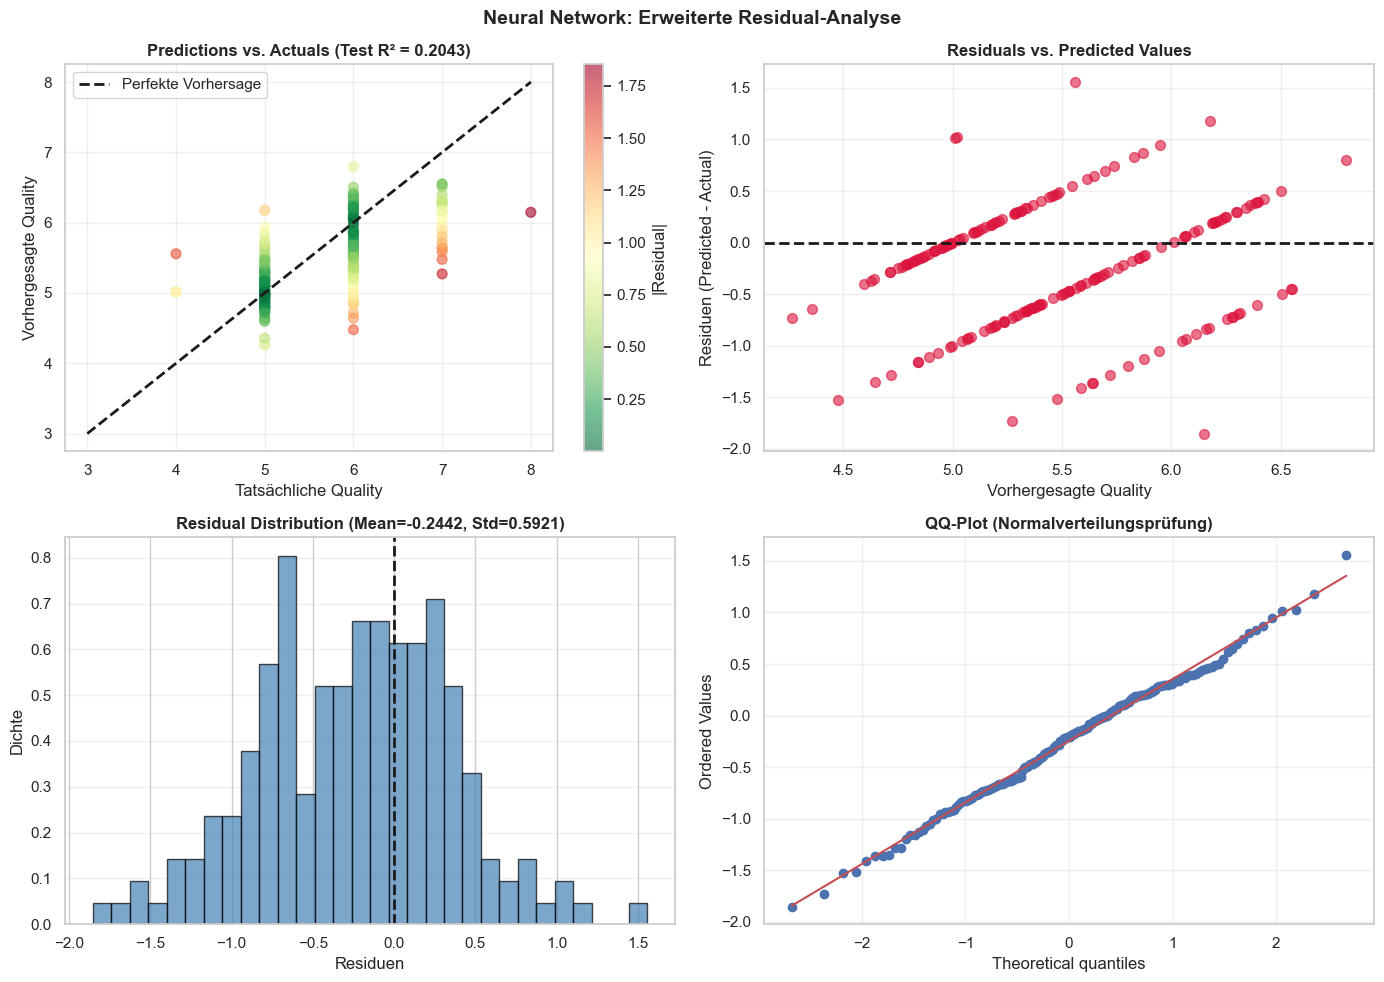


Shapiro-Wilk Normalverteilungstest:
  Statistik: 0.9956
  P-Wert: 0.8640
  Interpretation: Residuen sind normalverteilt


In [136]:
# ============================================================================
# ERWEITERTE RESIDUAL-ANALYSE
# ============================================================================

test_residuals = test_preds - y_test.reshape(-1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predictions vs Actuals (verbessert) - mit R² im Plot
scatter = axes[0, 0].scatter(y_test.reshape(-1), test_preds, alpha=0.6, c=np.abs(test_residuals), 
                              cmap='RdYlGn_r', s=50)
axes[0, 0].plot([3, 8], [3, 8], 'k--', linewidth=2, label='Perfekte Vorhersage')
axes[0, 0].set_xlabel('Tatsächliche Quality', fontsize=12)
axes[0, 0].set_ylabel('Vorhergesagte Quality', fontsize=12)
axes[0, 0].set_title(f'Predictions vs. Actuals (Test R² = {test_metrics["r2"]:.4f})', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='|Residual|')

# 2. Residuals vs Predicted (wie bei RF)
axes[0, 1].scatter(test_preds, test_residuals, alpha=0.6, color='crimson', s=50)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Vorhergesagte Quality', fontsize=12)
axes[0, 1].set_ylabel('Residuen (Predicted - Actual)', fontsize=12)
axes[0, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Residual Histogram
axes[1, 0].hist(test_residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black', density=True)
axes[1, 0].axvline(x=0, color='k', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuen', fontsize=12)
axes[1, 0].set_ylabel('Dichte', fontsize=12)
axes[1, 0].set_title(f'Residual Distribution (Mean={test_residuals.mean():.4f}, Std={test_residuals.std():.4f})', 
                     fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. QQ-Plot für Normalverteilung
sp_stats.probplot(test_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ-Plot (Normalverteilungsprüfung)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Neural Network: Erweiterte Residual-Analyse', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Normalverteilungstest
stat, p_value = sp_stats.shapiro(test_residuals[:min(5000, len(test_residuals))])  # Shapiro-Wilk begrenzt auf 5000
print(f"\nShapiro-Wilk Normalverteilungstest:")
print(f"  Statistik: {stat:.4f}")
print(f"  P-Wert: {p_value:.4f}")
print(f"  Interpretation: {'Residuen sind normalverteilt' if p_value > 0.05 else 'Residuen weichen von Normalverteilung ab'}")


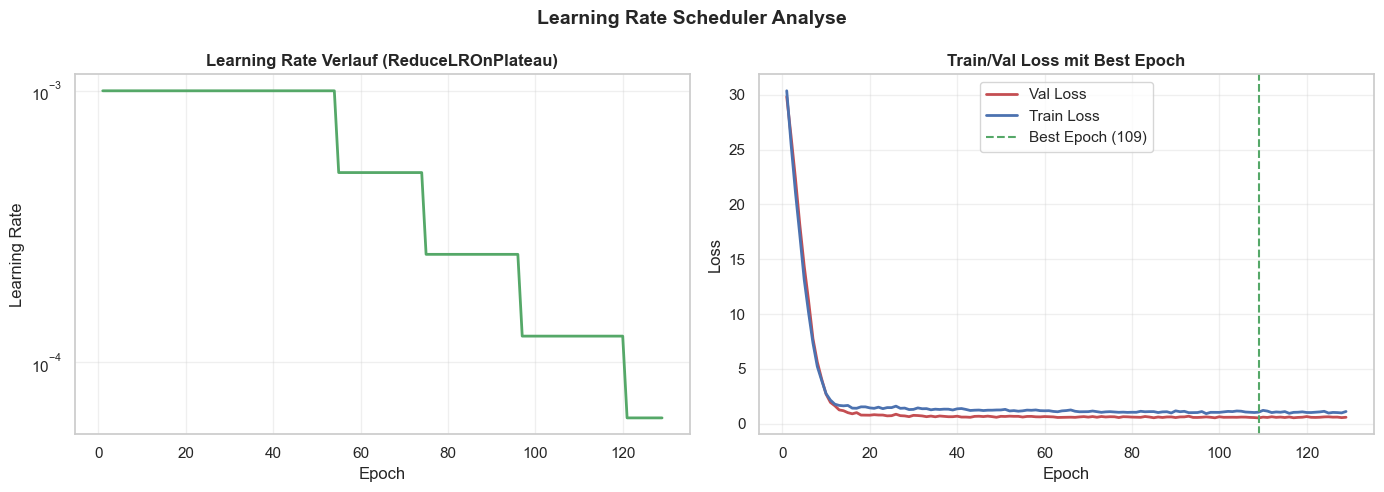


Learning Rate Änderungen:
  Epoch 1: LR = 0.001000
  Epoch 55: LR = 0.000500
  Epoch 75: LR = 0.000250
  Epoch 97: LR = 0.000125
  Epoch 121: LR = 0.000063


In [137]:
# ============================================================================
# LEARNING RATE VERLAUF (wenn LR Scheduler verwendet)
# ============================================================================

if 'learning_rate' in history_df.columns and USE_LR_SCHEDULER:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Learning Rate über Epochen
    axes[0].plot(history_df['epoch'], history_df['learning_rate'], 'g-', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Learning Rate', fontsize=12)
    axes[0].set_title('Learning Rate Verlauf (ReduceLROnPlateau)', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')
    
    # Val Loss mit LR-Änderungen markiert
    axes[1].plot(history_df['epoch'], history_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[1].plot(history_df['epoch'], history_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[1].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_epoch})')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Train/Val Loss mit Best Epoch', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Learning Rate Scheduler Analyse', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # LR-Änderungen anzeigen
    lr_changes = history_df[history_df['learning_rate'].diff() != 0]
    if len(lr_changes) > 1:
        print("\nLearning Rate Änderungen:")
        for _, row in lr_changes.iterrows():
            print(f"  Epoch {int(row['epoch'])}: LR = {row['learning_rate']:.6f}")


In [138]:
timestamp_str = datetime.now().strftime("%H-%M_%d-%m-%y")

history_path = ARTIFACT_DIR / f"{timestamp_str}_history.csv"
summary_path = ARTIFACT_DIR / f"{timestamp_str}_summary.csv"
model_path = ARTIFACT_DIR / f"{timestamp_str}_state_dict.pt"
scaler_path = ARTIFACT_DIR / f"{timestamp_str}_scaler.pkl"

best_row = history_df.loc[history_df["epoch"] == best_epoch].iloc[0]

summary = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_type": "WineQualityNet_11_64_32_1",
    "dataset": str(DATA_PATH),
    "n_train": X_train.shape[0],
    "n_val": X_val.shape[0],
    "n_test": X_test.shape[0],
    "n_features": X_train.shape[1],
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "max_epochs": MAX_EPOCHS,
    "patience": PATIENCE,
    "best_epoch": int(best_epoch),
    "training_time_seconds": training_time,
    "train_mse": float(train_metrics["mse"]),
    "train_rmse": float(train_metrics["rmse"]),
    "train_mae": float(train_metrics["mae"]),
    "train_r2": float(train_metrics["r2"]),
    "train_acc": float(train_acc),
    "val_mse": float(val_metrics["mse"]),
    "val_rmse": float(val_metrics["rmse"]),
    "val_mae": float(val_metrics["mae"]),
    "val_r2": float(val_metrics["r2"]),
    "val_acc": float(val_acc),
    "test_mse": float(test_metrics["mse"]),
    "test_rmse": float(test_metrics["rmse"]),
    "test_mae": float(test_metrics["mae"]),
    "test_r2": float(test_metrics["r2"]),
    "test_acc": float(test_acc),
    "history_filename": history_path.name,
    "model_filename": model_path.name,
    "scaler_filename": scaler_path.name,
}

history_df.to_csv(history_path, index=False)
pd.DataFrame([summary]).to_csv(summary_path, index=False)
torch.save(model.state_dict(), model_path)
joblib.dump(scaler, scaler_path)

print("Saved:")
print(f"- History: {history_path}")
print(f"- Summary: {summary_path}")
print(f"- Model state_dict: {model_path}")
print(f"- Scaler: {scaler_path}")


Saved:
- History: NN_model_history\13-52_07-01-26_history.csv
- Summary: NN_model_history\13-52_07-01-26_summary.csv
- Model state_dict: NN_model_history\13-52_07-01-26_state_dict.pt
- Scaler: NN_model_history\13-52_07-01-26_scaler.pkl


In [139]:
sample_features = df.iloc[0][feature_cols].values.astype(np.float32)
sample_scaled = scaler.transform(sample_features.reshape(1, -1))

model.eval()
with torch.no_grad():
    pred_quality_raw = model(torch.from_numpy(sample_scaled).float().to(device)).cpu().item()
    pred_quality_int = int(round_preds(np.array([pred_quality_raw]))[0])

print("Beispiel-Vorhersage (erste Zeile des Datensatzes):")
print(f"  Raw: {pred_quality_raw:.3f}")
print(f"  Rounded int: {pred_quality_int}")


Beispiel-Vorhersage (erste Zeile des Datensatzes):
  Raw: 5.120
  Rounded int: 5


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


C:\Users\dchmi\AppData\Local\Temp\ipykernel_5668\3642775920.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["quality"], palette="crest")


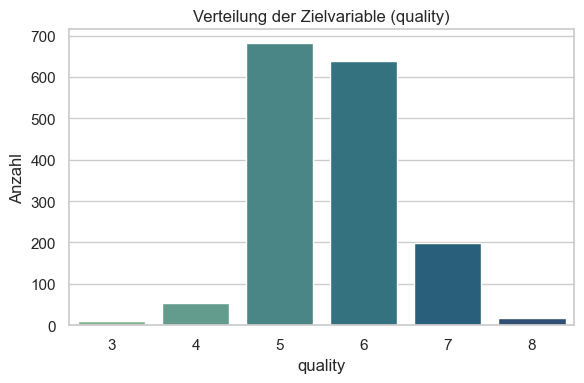

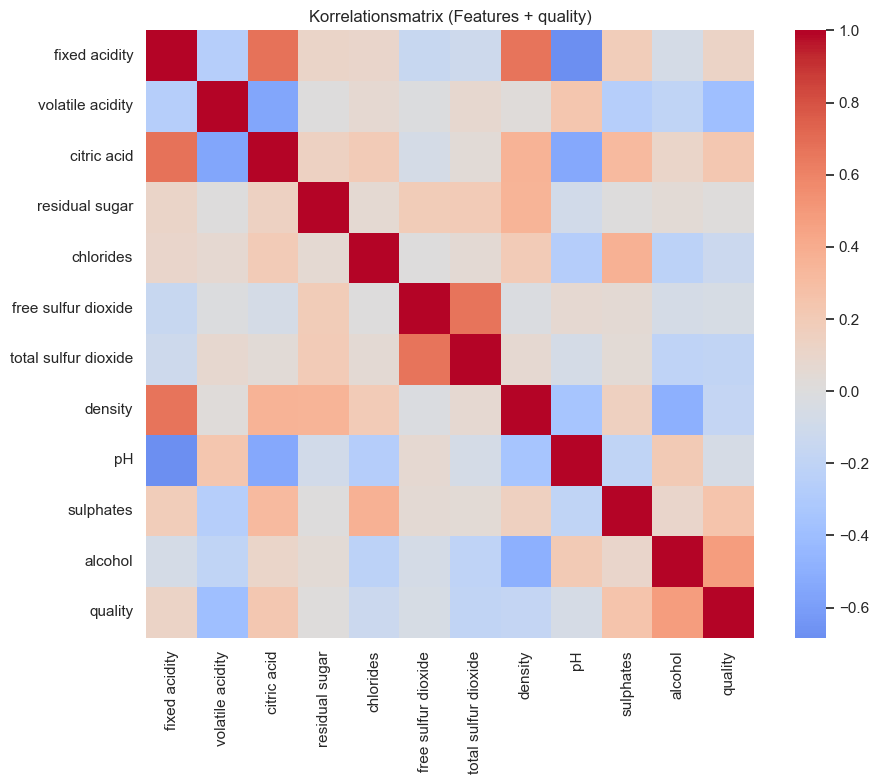

In [140]:
display(df.describe().T)

plt.figure(figsize=(6, 4))
sns.countplot(x=df["quality"], palette="crest")
plt.title("Verteilung der Zielvariable (quality)")
plt.xlabel("quality")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

corr = df[feature_cols + ["quality"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
plt.title("Korrelationsmatrix (Features + quality)")
plt.tight_layout()
plt.show()


In [141]:
display(history_df.head())
display(history_df.tail())

best_row = history_df.loc[history_df["epoch"] == best_epoch].iloc[0]
print(
    f"Best epoch {best_epoch}: val_loss={best_row['val_loss']:.4f}, train_loss={best_row['train_loss']:.4f}, "
    f"val_mae={best_row['val_mae']:.4f}"
)
print(
    f"Min Val-Loss: {history_df['val_loss'].min():.4f} | Min Val-MAE: {history_df['val_mae'].min():.4f}"
)


,epoch,train_loss,val_loss,train_mae,val_mae,learning_rate
0,1,30.354885,29.818252,5.443560,5.410146,0.001
1,2,25.458385,26.188838,4.979373,5.069978,0.001
2,3,21.078255,22.353710,4.517292,4.678606,0.001
3,4,17.181885,18.124781,4.055026,4.196216,0.001
4,5,13.145160,14.382274,3.511611,3.724560,0.001


,epoch,train_loss,val_loss,train_mae,val_mae,learning_rate
124,125,0.983055,0.639820,0.784748,0.629335,0.000063
125,126,1.039980,0.608232,0.800952,0.608844,0.000063
126,127,1.026003,0.613643,0.792351,0.618162,0.000063
127,128,0.997240,0.566241,0.792165,0.600329,0.000063
128,129,1.124768,0.597671,0.842993,0.612026,0.000063


Best epoch 109: val_loss=0.5410, train_loss=1.0615, val_mae=0.5738
Min Val-Loss: 0.5410 | Min Val-MAE: 0.5738


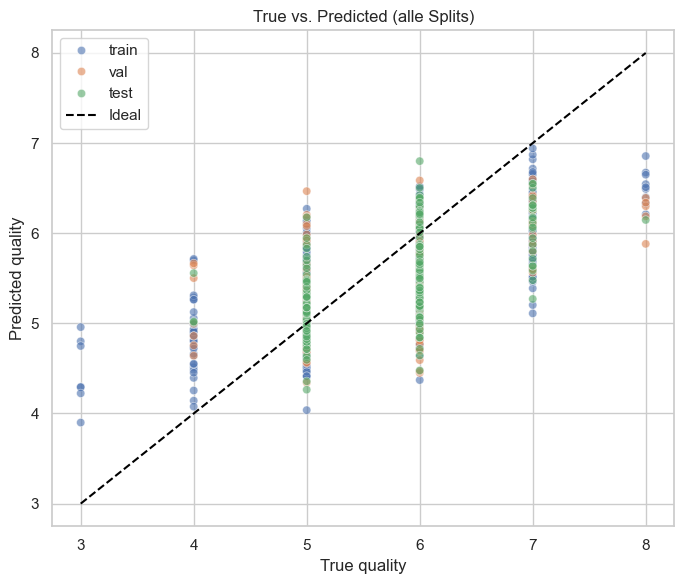

In [142]:
def build_preds_df(split_name: str, preds: np.ndarray, targets: np.ndarray) -> pd.DataFrame:
    return pd.DataFrame({"split": split_name, "y_true": targets.reshape(-1), "y_pred": preds})

preds_df = pd.concat(
    [
        build_preds_df("train", train_preds, y_train),
        build_preds_df("val", val_preds, y_val),
        build_preds_df("test", test_preds, y_test),
    ],
    ignore_index=True,
)

xy_min = preds_df[["y_true", "y_pred"]].min().min()
xy_max = preds_df[["y_true", "y_pred"]].max().max()
line = np.linspace(xy_min, xy_max, 100)

plt.figure(figsize=(7, 6))
sns.scatterplot(data=preds_df, x="y_true", y="y_pred", hue="split", alpha=0.6)
plt.plot(line, line, color="black", linestyle="--", label="Ideal")
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title("True vs. Predicted (alle Splits)")
plt.legend()
plt.tight_layout()
plt.show()


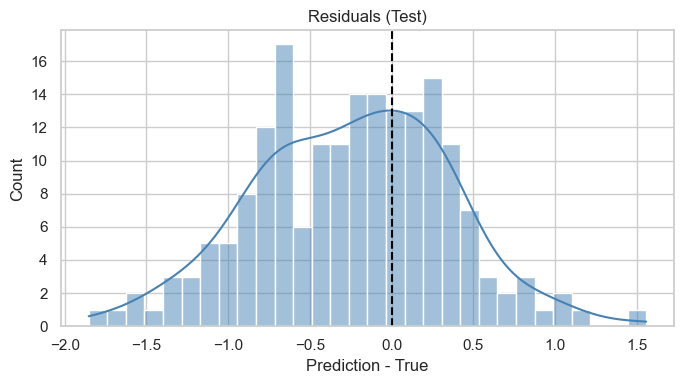

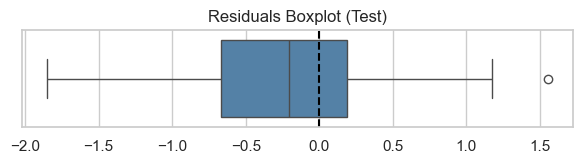

In [143]:
test_residuals = test_preds - y_test.reshape(-1)

plt.figure(figsize=(7, 4))
sns.histplot(test_residuals, bins=30, kde=True, color="steelblue")
plt.axvline(0, color="black", linestyle="--")
plt.title("Residuals (Test)")
plt.xlabel("Prediction - True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 1.8))
sns.boxplot(x=test_residuals, color="steelblue")
plt.axvline(0, color="black", linestyle="--")
plt.title("Residuals Boxplot (Test)")
plt.tight_layout()
plt.show()


In [144]:
test_err_df = pd.DataFrame(
    {
        "y_true": y_test.reshape(-1),
        "y_pred": test_preds,
    }
)
test_err_df["residual"] = test_err_df["y_pred"] - test_err_df["y_true"]
test_err_df["abs_error"] = test_err_df["residual"].abs()

display(test_err_df.sort_values("abs_error", ascending=False).head(10))


,y_true,y_pred,residual,abs_error
124,8.0,6.146998,-1.853002,1.853002
20,7.0,5.270864,-1.729136,1.729136
52,4.0,5.557203,1.557203,1.557203
78,6.0,4.477588,-1.522412,1.522412
28,7.0,5.478250,-1.521750,1.521750
40,7.0,5.585418,-1.414582,1.414582
182,7.0,5.635726,-1.364274,1.364274
109,7.0,5.641827,-1.358173,1.358173
49,6.0,4.643639,-1.356361,1.356361
21,6.0,4.716727,-1.283273,1.283273


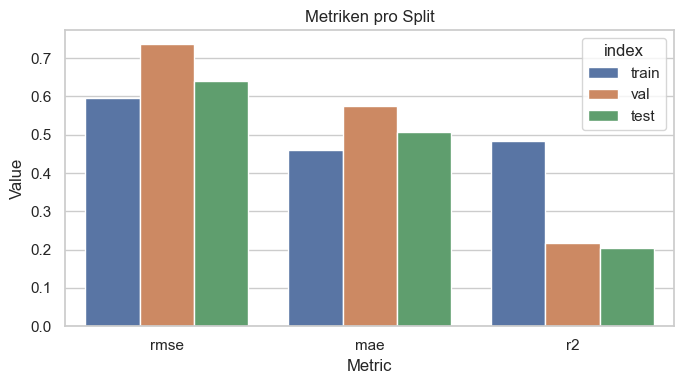

,mse,rmse,mae,r2,acc
train,0.355606,0.596327,0.459742,0.482709,0.612457
val,0.541044,0.735557,0.573822,0.217346,0.564516
test,0.410231,0.640493,0.507295,0.204331,0.591398


In [145]:
metrics_long = metrics_df.reset_index().melt(id_vars="index")
plt.figure(figsize=(7, 4))
sns.barplot(data=metrics_long[metrics_long["variable"].isin(["rmse", "mae", "r2"])], x="variable", y="value", hue="index")
plt.title("Metriken pro Split")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

metrics_df


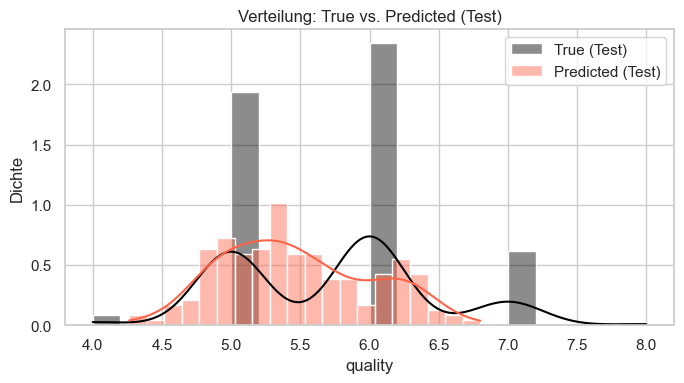

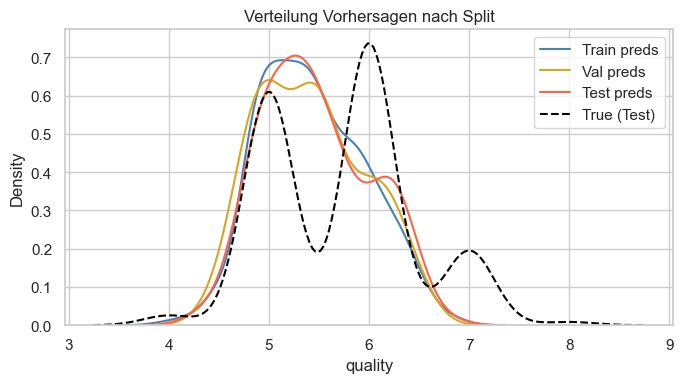

In [146]:
plt.figure(figsize=(7, 4))
sns.histplot(y_test.reshape(-1), bins=20, stat="density", kde=True, color="black", alpha=0.45, label="True (Test)")
sns.histplot(test_preds, bins=20, stat="density", kde=True, color="tomato", alpha=0.45, label="Predicted (Test)")
plt.xlabel("quality")
plt.ylabel("Dichte")
plt.title("Verteilung: True vs. Predicted (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Vergleich pro Split
plt.figure(figsize=(7, 4))
sns.kdeplot(train_preds, label="Train preds", color="steelblue")
sns.kdeplot(val_preds, label="Val preds", color="goldenrod")
sns.kdeplot(test_preds, label="Test preds", color="tomato")
sns.kdeplot(y_test.reshape(-1), label="True (Test)", color="black", linestyle="--")
plt.xlabel("quality")
plt.title("Verteilung Vorhersagen nach Split")
plt.legend()
plt.tight_layout()
plt.show()
